In [2]:
import pandas as pd
import matplotlib.pyplot as plt
# import json
# import requests

import config
plt.rcParams["figure.dpi"] = 144

In [1]:
# Using Brickset API
# year_list = list(range(1999, 2021))
# 
# res = json.loads(requests \
#                  .post("https://brickset.com/api/v3.asmx/getSets", \
#                        data = {'apiKey': config.api_key, 'userHash': config.user_hash, \
#                                'params': f"{{'theme': 'Creator', 'year': '{year_list}', \
#                                'pageSize': 500}}"}).text)
# 
# sets = res['sets']
# minifigs_count = []
# for set in sets:
#     minifigs_count.append(set['setID'])
    
# res['matches']

# Questions
- Are longstanding current themes more likely to have a greater number of set releases per year?
- Has the price per piece increased over time? (Pick a specific theme, e.g. Star Wars)
    - Does this align with inflation? (Pick a specific currency)
- Are some themes more expensive than others? (Pick a specific year range)

In [4]:
curr_themes = ['Architecture', 'Brick Sketches', 'BrickHeadz', 'City', 'Classic', \
               'Collectable Minifigures', 'Creator', 'Creator Expert', 'DC Comics Super Heroes' \
                'Disney', 'DOTS', 'Duplo', 'Education', 'Friends', 'Harry Potter', \
               'Hidden Side', 'Ideas', 'Jurassic World', 'LEGO Art', 'Marvel Super Heroes', \
               'Mindstorms', 'Minecraft', 'Minions: The Rise of Gru', 'Monkie Kid', 'Ninjago' \
               'Overwatch', 'Powered Up', 'Speed Champions', 'Star Wars', 'Super Heroes', \
               'Super Mario', 'Technic ', 'Trolls World Tour']

year_list = list(range(1978, 2021))

data = pd.read_csv('allsets.csv')
print('Table has shape:', data.shape)

Table has shape: (16806, 24)


## Visualizing numerical values: Year, Minifigs, Pieces, USRetailPrice

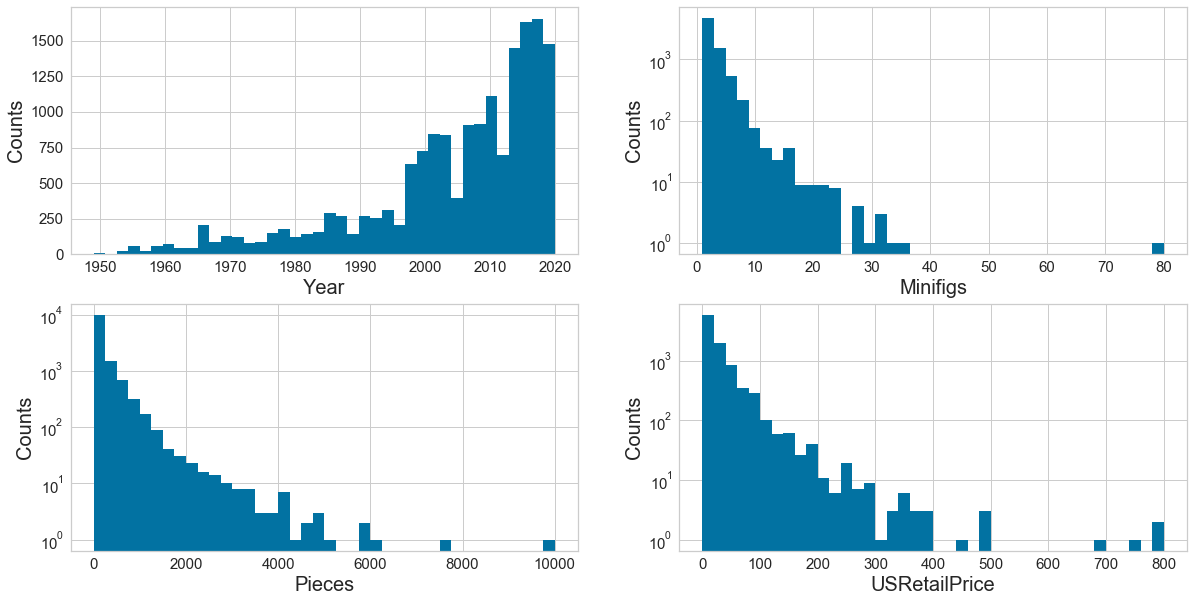

In [26]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)
fig, axes = plt.subplots(nrows = 2, ncols = 2)
num_features = ['Year', 'Minifigs', 'Pieces', 'USRetailPrice'] # features of interest
axes = axes.ravel()
for i, ax in enumerate(axes):
    if i == 0:
        ax.hist(data[num_features[i]].dropna(), bins=40)
    else:
        ax.hist(data[num_features[i]].dropna(), bins=40, log=True)
    ax.set_xlabel(num_features[i], fontsize=20)
    ax.set_ylabel('Counts', fontsize=20)
    ax.tick_params(axis='both', labelsize=15)


## Visualizing categorical values: ThemeGroup
- ThemeGroup has 16 categories while Theme has 148

Text(0.5, 0, 'Count')

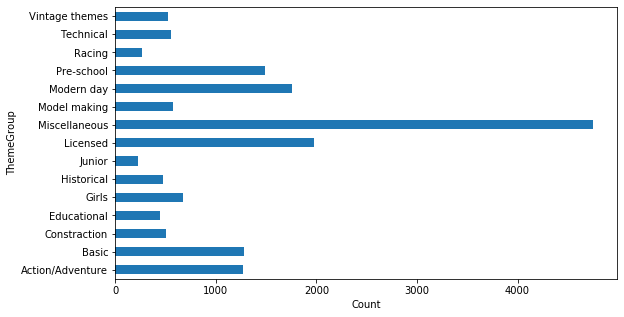

In [6]:
ax = data.groupby('ThemeGroup').size().plot.barh(figsize=(9,5))
ax.set_xlabel("Count")

## Are the numerical values correlated?

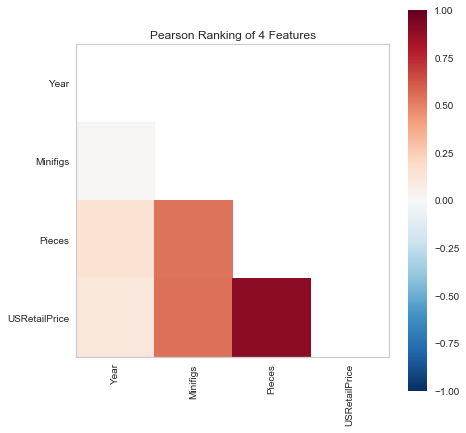

In [30]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (7,7)

from yellowbrick.features import Rank2D
X = data[num_features].dropna().to_numpy()

visualizer = Rank2D(features=num_features, algorithm='pearson')
visualizer.fit(X)
visualizer.transform(X)
visualizer.show()

A few things of note (that should be prior knowledge for Lego fans!):
- The number of pieces is strongly correlated with price
- Larger, more expensive sets are more likely to have more minifigures

More interestingly, there is a weak trend of sets getting bigger and more expensive over the years.